**PROJECT ARCHITECTURE**

     BUSINESS QUESTION??

     Where is the “Blue Ocean” in the snack aisle — meaning:
Where do we see LOW competition (few products) but HIGH consumer-aligned nutrition (High Protein + Low Sugar)?

So this is essentially:

Supply analysis (what exists in market)

Nutritional positioning analysis

Gap identification

Strategic recommendation

2.    **DATA**
We will use data from Open Food Facts.

3. **TOOLING REQUIREMENTS**

We are using cloud-hosted notebook- Google Colab.

4. **User Stories and Acceptance Criteria**

STORY 1: Data Ingestion and "The Clean Up".

**LIBRARIES IMPORTATION.**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display import Markdown

warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["figure.dpi"] = 100

In [ ]:
# ============================================================
# Open Food Facts - Download & Create 500k Row Subset
# ============================================================

import pandas as pd
import requests
import os

# ── 1. Download the CSV (streamed, so memory stays low) ──────
url = "https://static.openfoodfacts.org/data/en.openfoodfacts.org.products.csv"
local_file = "openfoodfacts_full.csv"

if not os.path.exists(local_file):
    print("Downloading dataset (3GB+) — this will take a few minutes...")
    response = requests.get(url, stream=True)
    total = int(response.headers.get("content-length", 0))
    downloaded = 0

    with open(local_file, "wb") as f:
        for chunk in response.iter_content(chunk_size=1024 * 1024):  # 1 MB chunks
            f.write(chunk)
            downloaded += len(chunk)
            print(f"\r  {downloaded / 1e9:.2f} GB downloaded", end="")

    print("\nDownload complete!")
else:
    print(f"File already exists: {local_file}")

# ── 2. Read only the first 500,000 rows ─────────────────────
print("\nReading first 500,000 rows...")

df = pd.read_csv(
    local_file,
    nrows=500_000,
    sep="\t",                  # Open Food Facts uses TAB as delimiter
    low_memory=False,
    on_bad_lines="skip",       # skip malformed rows
    encoding="utf-8",
)

print(f"Shape: {df.shape}")
print(f"Columns ({len(df.columns)}): {df.columns.tolist()[:10]} ...")

# ── 3. Save the subset so you never re-process again ─────────
subset_file = "openfoodfacts_500k.csv"
df.to_csv(subset_file, index=False)
print(f"\nSubset saved → {subset_file}")
print(df.head(3))

  12.63 GB downloaded
Download complete!

Reading first 500,000 rows...
Shape: (500000, 215)
Columns (215): ['code', 'url', 'creator', 'created_t', 'created_datetime', 'last_modified_t', 'last_modified_datetime', 'last_modified_by', 'last_updated_t', 'last_updated_datetime'] ...

Subset saved → openfoodfacts_500k.csv
   code                                                url  \
0     2  http://world-en.openfoodfacts.org/product/0000...   
1     3  http://world-en.openfoodfacts.org/product/0000...   
2     4  http://world-en.openfoodfacts.org/product/0000...   

                      creator   created_t      created_datetime  \
0  openfoodfacts-contributors  1760861583  2025-10-19T08:13:03Z   
1  openfoodfacts-contributors  1752485388  2025-07-14T09:29:48Z   
2  openfoodfacts-contributors  1768903196  2026-01-20T09:59:56Z   

   last_modified_t last_modified_datetime last_modified_by  last_updated_t  \
0       1760861586   2025-10-19T08:13:06Z              NaN    1.760862e+09   
1      

In [ ]:
# Load only the columns we need to keep memory usage manageable
COLS = [
    "product_name", "brands", "categories_tags", "countries_en",
    "ingredients_text", "nutriscore_grade", "nova_group",
    "sugars_100g", "proteins_100g", "fat_100g", "fiber_100g",
    "energy-kcal_100g", "saturated-fat_100g", "salt_100g",
    "carbohydrates_100g",
]

raw = pd.read_csv("openfoodfacts_500k.csv", usecols=COLS, low_memory=False)
print(f"Raw dataset: {raw.shape[0]:,} rows × {raw.shape[1]} columns")
raw.head(3)

Raw dataset: 500,000 rows × 15 columns


,product_name,brands,categories_tags,countries_en,ingredients_text,nutriscore_grade,nova_group,energy-kcal_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g
0,NaN,NaN,NaN,Germany,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


So understanding the data we have

Dataset: Open Food Facts

Subsets: 500,000

Column intended to use: product name(Remove unnamed junk),categories_tags(Needed for Grouping), sugar_100g(Sugar per 100g),protein_100g(Protein per 100g), fat_100g(Optional).

**STEP 1 - Data Cleaning Strategy** (STORY 1)

Goal:

Create a clean dataset that:

Removes invalid nutritional values

Handles missing values

Removes impossible biological entries

1.1 Handle Missing Values

We MUST remove rows where:

I.product_name is null

II.sugars_100g is null

III.proteins_100g is null

Why?
Because those are essential for scatter plot analysis.

In [ ]:
# Missingness overview for key nutrient columns
key_cols = ["product_name", "sugars_100g", "proteins_100g", "fat_100g",
            "fiber_100g", "categories_tags", "ingredients_text"]

missing = raw[key_cols].isnull().sum().to_frame("missing")
missing["pct"] = (missing["missing"] / len(raw) * 100).round(1)
missing


,missing,pct
product_name,16218,3.2
sugars_100g,94537,18.9
proteins_100g,78057,15.6
fat_100g,78524,15.7
fiber_100g,178205,35.6
categories_tags,230004,46.0
ingredients_text,231458,46.3


**1.2 Handle Impossible Values**

Biologically impossible:

Sugar < 0

Protein < 0

Sugar > 100g per 100g

Protein > 100g per 100g

(We cannot have more than 100g of nutrient per 100g food.)

In [ ]:
# --- Cleaning ---
# 1. Drop rows missing the three mandatory fields
df = raw.dropna(subset=["product_name", "sugars_100g", "proteins_100g"]).copy()
print(f"After dropping nulls in product_name/sugars/proteins: {len(df):,} rows")

# 2. Remove biologically impossible values (per 100 g, no nutrient can exceed 100)
nutrient_cols = ["sugars_100g", "proteins_100g", "fat_100g", "fiber_100g",
                 "saturated-fat_100g", "salt_100g", "carbohydrates_100g"]

for col in nutrient_cols:
    if col in df.columns:
        before = len(df)
        df = df[(df[col].isna()) | ((df[col] >= 0) & (df[col] <= 100))]
        removed = before - len(df)
        if removed:
            print(f"  Removed {removed:,} rows with {col} outside [0, 100]")

# 3. Energy sanity check: kcal can go up to ~900 (pure fat)
if "energy-kcal_100g" in df.columns:
    before = len(df)
    df = df[(df["energy-kcal_100g"].isna()) | ((df["energy-kcal_100g"] >= 0) & (df["energy-kcal_100g"] <= 900))]
    print(f"  Removed {before - len(df):,} rows with impossible energy values")

print(f"\n Clean dataset: {len(df):,} rows")

After dropping nulls in product_name/sugars/proteins: 400,016 rows
  Removed 5,219 rows with sugars_100g outside [0, 100]
  Removed 757 rows with proteins_100g outside [0, 100]
  Removed 3,529 rows with fat_100g outside [0, 100]
  Removed 50 rows with fiber_100g outside [0, 100]
  Removed 5 rows with saturated-fat_100g outside [0, 100]
  Removed 337 rows with salt_100g outside [0, 100]
  Removed 4,473 rows with carbohydrates_100g outside [0, 100]
  Removed 921 rows with impossible energy values

 Clean dataset: 384,725 rows


In [ ]:
# Quick distribution check on the cleaned data
df[["sugars_100g", "proteins_100g", "fat_100g", "fiber_100g"]].describe().round(1)

,sugars_100g,proteins_100g,fat_100g,fiber_100g
count,384725.0,384725.0,383814.0,301229.0
mean,14.6,7.5,11.6,2.7
std,20.2,9.4,15.4,4.6
min,0.0,0.0,0.0,0.0
25%,1.1,0.8,0.0,0.0
50%,4.9,4.8,5.0,1.3
75%,21.0,10.2,18.4,3.5
max,100.0,100.0,100.0,100.0


**1.3 Optional: Remove Extreme Outliers**
Sometimes data contains:

0 protein AND 0 sugar (likely missing)

Extremely high sugar like 99g candy only

We will not remove valid extremes yet  we want to see clusters first.

In [ ]:
sugar_cutoff = df["sugars_100g"].quantile(0.99)
protein_cutoff = df["proteins_100g"].quantile(0.99)

df = df[
    (df["sugars_100g"] <= sugar_cutoff) &
    (df["proteins_100g"] <= protein_cutoff)
]

 **DELIVERABLE FOR STORY 1**

In [ ]:
print("Before cleaning:", df.shape)

df_clean = df.copy()

df_clean = df_clean.dropna(subset=[
    "product_name",
    "sugars_100g",
    "proteins_100g"
])

print("After dropna:", df_clean.shape)

df_clean = df_clean[
    (df_clean["sugars_100g"] >= 0) &
    (df_clean["sugars_100g"] <= 100) &
    (df_clean["proteins_100g"] >= 0) &
    (df_clean["proteins_100g"] <= 100)
]

print("After biological filter:", df_clean.shape)

Before cleaning: (393745, 4)
After dropna: (392392, 4)
After biological filter: (391120, 4)


 **STEP 2 - THE CATEGORY WRANGLER (STRORY 2)**


**The Column:**

categories_tags likes en:snacks, en:sweetsnacks, en:biscuits

So we need to

1. Parse it

2. Create readable categories

3. Create 5+ high level buskets

So basically we are creating a functiom that assigns

Sweet Snacks(sweet-snacks,chocolate,candy,biscuits),

Savory Snacks(chips, crisps, nuts,savory)

Beverages(drinks, beverages)

Product Products(protein bars, protein)

Breakfast(cereals, granola)

other

In [ ]:
CATEGORY_MAP = {
    "Dairy":       ["dairy", "cheese", "yogurt", "yoghurt", "butter", "cream", "milk"],
    "Meat & Seafood":   ["meat", "chicken", "beef", "pork", "fish", "seafood", "sausage", "ham", "turkey"],
    "Sweets":      ["sweet", "chocolate", "candy", "confection", "biscuit", "cookie", "cake", "pastry", "dessert", "ice-cream", "ice cream"],
    "Snacks":      ["snack", "chip", "crisp", "cracker", "pretzel", "popcorn", "nut"],
    "Beverages":   ["beverage", "drink", "juice", "water", "soda", "tea", "coffee"],
    "Cereals & Grains": ["cereal", "grain", "bread", "pasta", "rice", "flour", "oat", "wheat"],
    "Fruits & Vegetables": ["fruit", "vegetable", "salad", "legume", "bean", "lentil", "tomato", "potato"],
    "Condiments & Sauces": ["sauce", "condiment", "dressing", "mayonnaise", "ketchup", "mustard", "vinegar", "oil", "spice", "seasoning", "spread"],
}
def assign_category(tags: str) -> str:
    """Return the first matching Primary Category, or 'Other'."""
    if not isinstance(tags, str):
        return "Other"
    tags_lower = tags.lower()
    for category, keywords in CATEGORY_MAP.items():
        if any(kw in tags_lower for kw in keywords):
            return category
    return "Other"


df["primary_category"] = df["categories_tags"].apply(assign_category)

cat_counts = df["primary_category"].value_counts()
print(f"Assigned {len(cat_counts)} categories:\n")
print(cat_counts.to_string())

Assigned 9 categories:

primary_category
Other                  205668
Beverages               56739
Sweets                  47875
Snacks                  26098
Dairy                   23007
Meat & Seafood          15435
Condiments & Sauces     14340
Fruits & Vegetables      2512
Cereals & Grains         2071


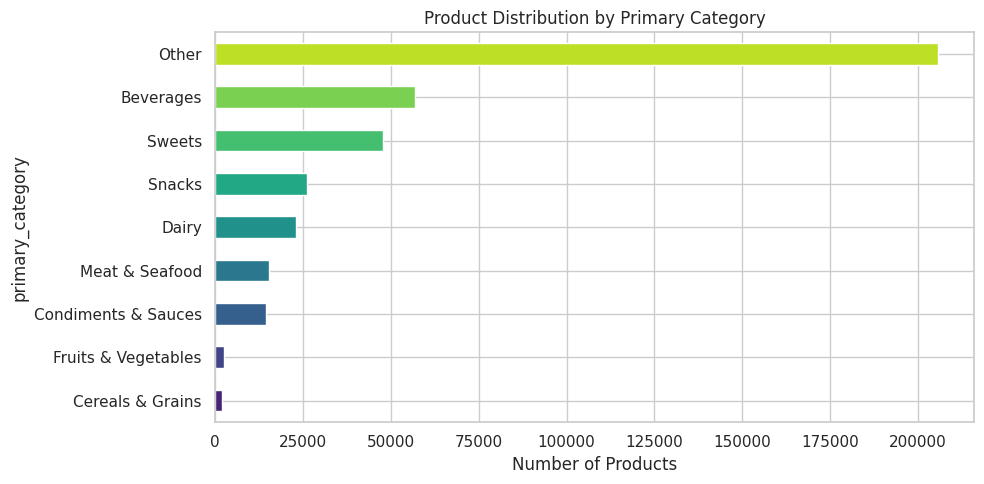

In [ ]:
# Category distribution bar chart
fig, ax = plt.subplots(figsize=(10, 5))
cat_counts.sort_values().plot.barh(ax=ax, color=sns.color_palette("viridis", len(cat_counts)))
ax.set_xlabel("Number of Products")
ax.set_title("Product Distribution by Primary Category")
plt.tight_layout()
plt.show()

**STEP 3 — The Nutrient Matrix (Story 3)**

Now we build the strategic insight.

We plot:

X-axis → sugars_100g

Y-axis → proteins_100g

Color → Primary_Category : The shaded Blue Ocean quadrant (High Protein + Low Sugar) is where market gaps live.

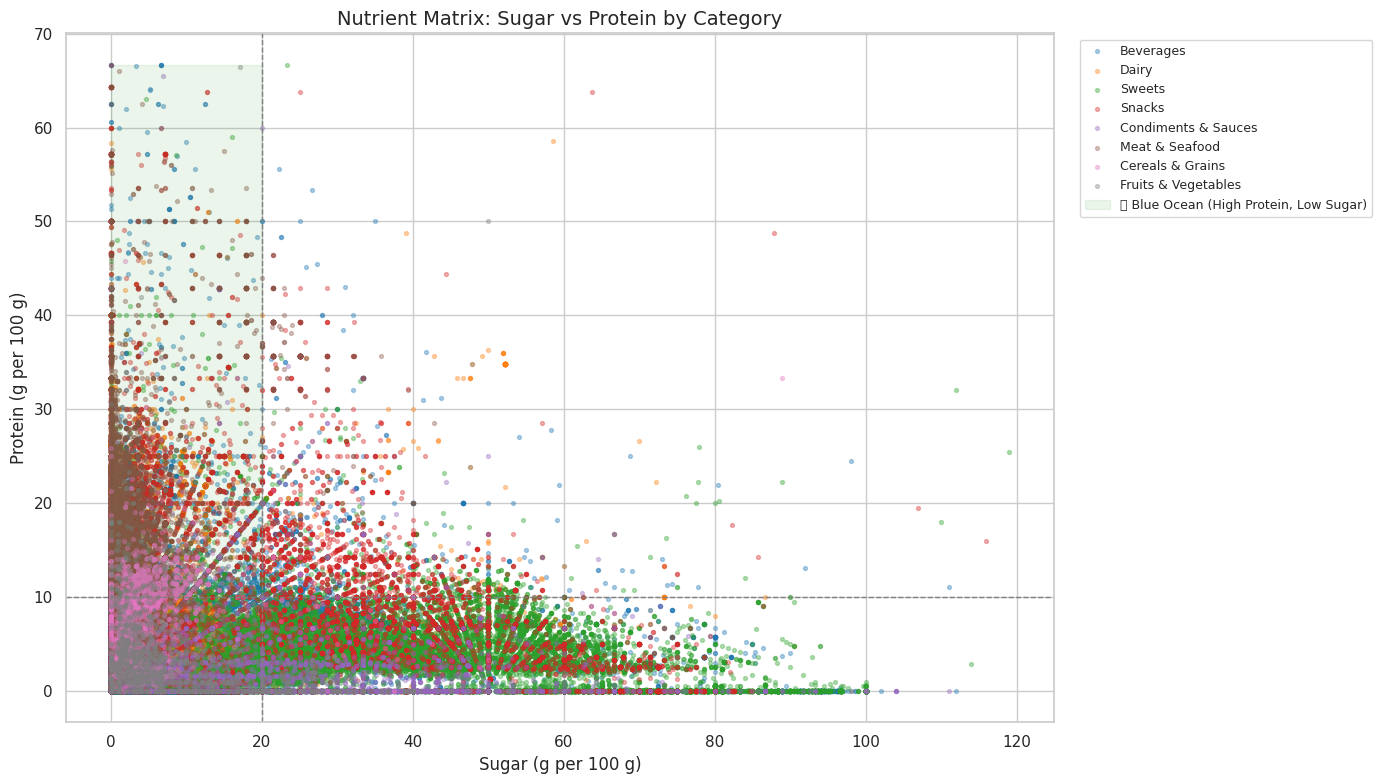

In [ ]:
# Define thresholds for the quadrant overlay
SUGAR_THRESHOLD = 20   # g per 100 g
PROTEIN_THRESHOLD = 10  # g per 100 g

# Work with non-Other categories for clarity (Other is noisy)
plot_df = df[df["primary_category"] != "Other"].copy()

fig, ax = plt.subplots(figsize=(14, 8))

# Scatter by category
categories = plot_df["primary_category"].unique()
palette = sns.color_palette("tab10", len(categories))

for cat, color in zip(categories, palette):
    subset = plot_df[plot_df["primary_category"] == cat]
    ax.scatter(subset["sugars_100g"], subset["proteins_100g"],
               label=cat, alpha=0.35, s=8, color=color)

# Quadrant lines
ax.axvline(SUGAR_THRESHOLD, color="grey", ls="--", lw=1)
ax.axhline(PROTEIN_THRESHOLD, color="grey", ls="--", lw=1)

# Highlight the Blue Ocean quadrant
ax.fill_between([0, SUGAR_THRESHOLD], PROTEIN_THRESHOLD, plot_df["proteins_100g"].max(),
                alpha=0.08, color="green", label="🟢 Blue Ocean (High Protein, Low Sugar)")

ax.set_xlabel("Sugar (g per 100 g)", fontsize=12)
ax.set_ylabel("Protein (g per 100 g)", fontsize=12)
ax.set_title("Nutrient Matrix: Sugar vs Protein by Category", fontsize=14)
ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=9)
plt.tight_layout()
plt.show()

In [ ]:
# Per-category breakdown: what % of each category falls in the Blue Ocean?
plot_df["blue_ocean"] = (
    (plot_df["sugars_100g"] <= SUGAR_THRESHOLD) &
    (plot_df["proteins_100g"] >= PROTEIN_THRESHOLD)
)

gap = (
    plot_df.groupby("primary_category")["blue_ocean"]
    .agg(["sum", "count"])
    .rename(columns={"sum": "blue_ocean_count", "count": "total"})
)
gap["blue_ocean_pct"] = (gap["blue_ocean_count"] / gap["total"] * 100).round(1)
gap = gap.sort_values("blue_ocean_pct", ascending=False)
print("Blue Ocean penetration by category:\n")
gap

Blue Ocean penetration by category:



,blue_ocean_count,total,blue_ocean_pct
primary_category,,,
Meat & Seafood,13359,15435,86.6
Dairy,9499,23007,41.3
Cereals & Grains,838,2071,40.5
Snacks,7033,26098,26.9
Beverages,10170,56739,17.9
Condiments & Sauces,774,14340,5.4
Fruits & Vegetables,127,2512,5.1
Sweets,1912,47875,4.0


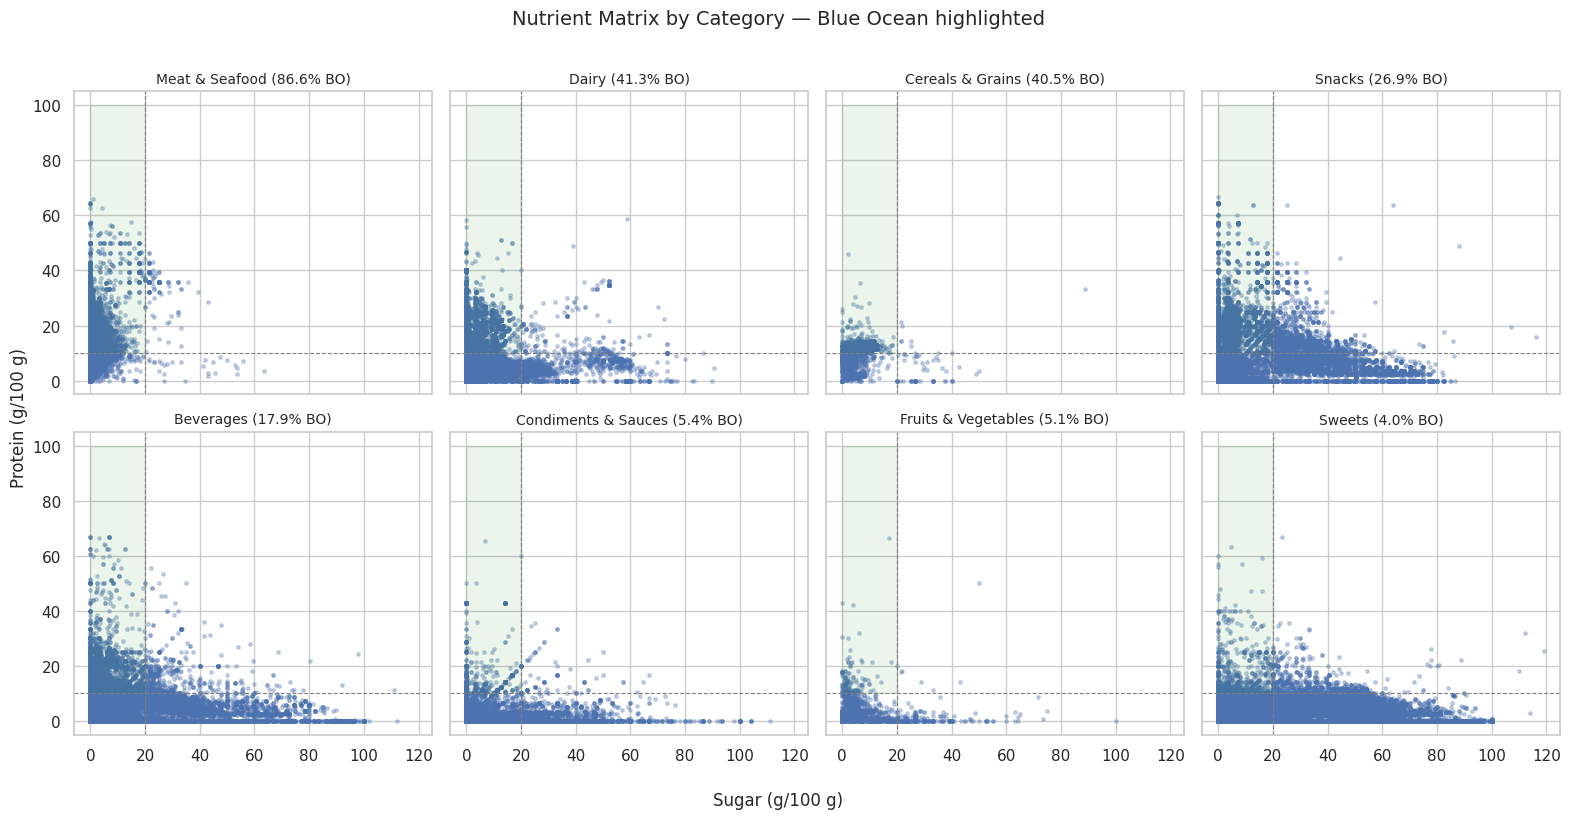

In [ ]:
# Faceted scatter: one subplot per category
cats_to_plot = gap.index.tolist()
n = len(cats_to_plot)
cols = 4
rows = int(np.ceil(n / cols))

fig, axes = plt.subplots(rows, cols, figsize=(16, rows * 4), sharex=True, sharey=True)
axes = axes.flatten()

for i, cat in enumerate(cats_to_plot):
    ax = axes[i]
    subset = plot_df[plot_df["primary_category"] == cat]
    ax.scatter(subset["sugars_100g"], subset["proteins_100g"], alpha=0.3, s=6)
    ax.axvline(SUGAR_THRESHOLD, color="grey", ls="--", lw=0.8)
    ax.axhline(PROTEIN_THRESHOLD, color="grey", ls="--", lw=0.8)
    ax.fill_between([0, SUGAR_THRESHOLD], PROTEIN_THRESHOLD, 100,
                    alpha=0.08, color="green")
    ax.set_title(f"{cat} ({gap.loc[cat, 'blue_ocean_pct']}% BO)", fontsize=10)

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

fig.supxlabel("Sugar (g/100 g)", fontsize=12)
fig.supylabel("Protein (g/100 g)", fontsize=12)
fig.suptitle("Nutrient Matrix by Category — Blue Ocean highlighted", fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

**STEP 4 — The Recommendation (Story 4)**

After counting clusters, we answer:

Which category has LOW competition but some presence in High Protein + Low Sugar?

In [ ]:
# Find the category with the LOWEST Blue-Ocean penetration but a meaningful product count
# (i.e., big category where almost nothing is high-protein / low-sugar)
opportunity = gap[gap["total"] >= 500].sort_values("blue_ocean_pct", ascending=True)
print("Categories ranked by gap (lowest Blue-Ocean %):")
opportunity

Categories ranked by gap (lowest Blue-Ocean %):


,blue_ocean_count,total,blue_ocean_pct
primary_category,,,
Sweets,1912,47875,4.0
Fruits & Vegetables,127,2512,5.1
Condiments & Sauces,774,14340,5.4
Beverages,10170,56739,17.9
Snacks,7033,26098,26.9
Cereals & Grains,838,2071,40.5
Dairy,9499,23007,41.3
Meat & Seafood,13359,15435,86.6


In [ ]:
# Build recommendation from the top opportunity row
top = opportunity.iloc[0]
top_cat = top.name

# Target specs: aim for 75th-percentile protein among existing BO products in that category
bo_products = plot_df[
    (plot_df["primary_category"] == top_cat) & (plot_df["blue_ocean"])
]

if len(bo_products) > 5:
    target_protein = round(bo_products["proteins_100g"].quantile(0.75))
    target_sugar   = max(5, round(bo_products["sugars_100g"].quantile(0.25)))
else:
    # Fallback: use overall thresholds
    target_protein = PROTEIN_THRESHOLD
    target_sugar   = SUGAR_THRESHOLD // 2

insight = (
    f"Based on the data, the biggest market opportunity is in **{top_cat}**, "
    f"specifically targeting products with **{target_protein} g of protein** "
    f"and less than **{target_sugar} g of sugar** per 100 g.\n\n"
    f"Only **{top['blue_ocean_pct']}%** of the {int(top['total']):,} products in this "
    f"category currently sit in the High-Protein / Low-Sugar quadrant — a clear Blue Ocean."
)

Markdown(f"###  Key Insight\n\n{insight}")

###  Key Insight

Based on the data, the biggest market opportunity is in **Sweets**, specifically targeting products with **13 g of protein** and less than **5 g of sugar** per 100 g.

Only **4.0%** of the 47,875 products in this category currently sit in the High-Protein / Low-Sugar quadrant — a clear Blue Ocean.

**STEP 5 — Bonus: Hidden Gem (Protein Ingredients)**

Scan ingredients_text across all Blue-Ocean products and rank the most common protein-rich ingredients.


In [ ]:
# High-protein cluster across all categories
hp_df = df[
    (df["proteins_100g"] >= PROTEIN_THRESHOLD) &
    (df["sugars_100g"] <= SUGAR_THRESHOLD) &
    (df["ingredients_text"].notna())
].copy()

print(f"High-Protein / Low-Sugar products with ingredients text: {len(hp_df):,}")

# Known protein-rich ingredient keywords
PROTEIN_KEYWORDS = [
    "whey", "casein", "soy", "pea protein", "egg", "chicken",
    "beef", "pork", "fish", "salmon", "tuna", "turkey",
    "milk", "lentil", "chickpea", "peanut", "almond",
    "oat", "hemp", "collagen", "gelatin", "tofu",
]

counts = {}
for kw in PROTEIN_KEYWORDS:
    counts[kw] = hp_df["ingredients_text"].str.lower().str.contains(kw, na=False).sum()

protein_sources = pd.Series(counts).sort_values(ascending=False)
protein_sources = protein_sources[protein_sources > 0]

print("\nTop protein-source ingredients in Blue-Ocean products:\n")
print(protein_sources.head(10).to_string())

High-Protein / Low-Sugar products with ingredients text: 50,740

Top protein-source ingredients in Blue-Ocean products:

milk       16319
soy        12907
pork        5305
whey        5245
chicken     4454
beef        4309
oat         4306
peanut      4103
egg         3262
almond      2565


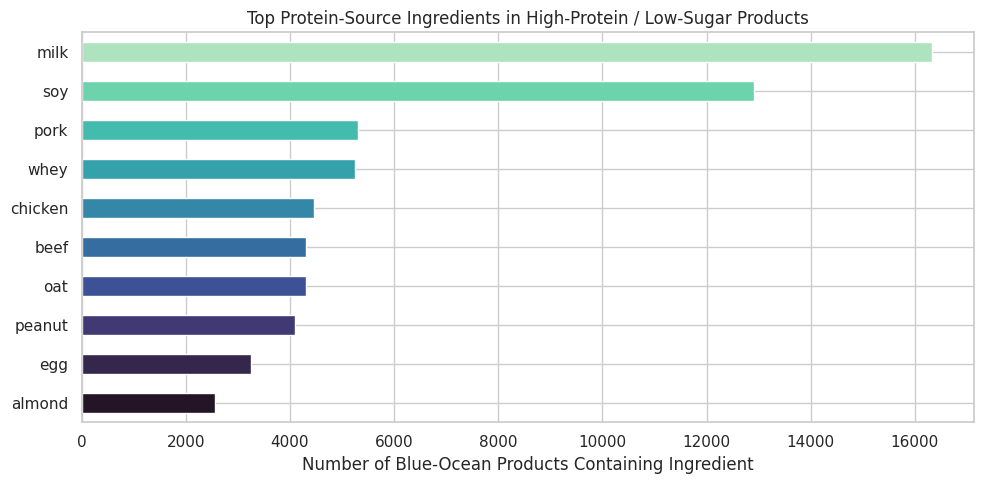

###  Top 3 Protein Sources

1. **Milk**
2. **Soy**
3. **Pork**

In [ ]:
# Visualise top protein sources
top_sources = protein_sources.head(10)

fig, ax = plt.subplots(figsize=(10, 5))
top_sources.sort_values().plot.barh(ax=ax, color=sns.color_palette("mako", len(top_sources)))
ax.set_xlabel("Number of Blue-Ocean Products Containing Ingredient")
ax.set_title("Top Protein-Source Ingredients in High-Protein / Low-Sugar Products")
plt.tight_layout()
plt.show()

top3 = protein_sources.head(3).index.tolist()
Markdown(f"###  Top 3 Protein Sources\n\n"
         f"1. **{top3[0].title()}**\n"
         f"2. **{top3[1].title()}**\n"
         f"3. **{top3[2].title()}**")

**STEP 6 — Candidate’s Choice (MY Differentiator)**

We will look at **"NutriScore Gap Analysis”.**


NutriScore (A–E) is increasingly influential on EU packaging. Categories dominated by D/E grades present the biggest on-shelf advantage for a reformulated, healthier product.



In [ ]:
# Define your top-level category keywords to map
CATEGORY_MAP = {
    "beverages": "Beverages",
    "dairy": "Dairy",
    "meats": "Meats",
    "fish": "Fish & Seafood",
    "cereals": "Cereals & Grains",
    "snacks": "Snacks",
    "fruits": "Fruits & Vegetables",
    "vegetables": "Fruits & Vegetables",
    "legumes": "Legumes",
    "sauces": "Sauces & Condiments",
    "frozen": "Frozen Foods",
    "sweets": "Sweets",
    "breads": "Breads & Bakery",
}

def assign_category(tags):
    if pd.isna(tags):
        return "Other"
    tags_lower = str(tags).lower()
    for key, label in CATEGORY_MAP.items():
        if key in tags_lower:
            return label
    return "Other"

df["primary_category"] = df["categories_tags"].apply(assign_category)

print(df["primary_category"].value_counts())

primary_category
Other                  217916
Beverages               69398
Snacks                  54742
Sauces & Condiments     14012
Frozen Foods            13075
Meats                    9348
Dairy                    4370
Fish & Seafood           1787
Fruits & Vegetables        51
Cereals & Grains           15
Legumes                     9
Sweets                      1
Breads & Bakery             1
Name: count, dtype: int64


In [ ]:
# Map NutriScore letters to numeric for aggregation
SCORE_MAP = {"a": 1, "b": 2, "c": 3, "d": 4, "e": 5}

scored = df[df["nutriscore_grade"].isin(SCORE_MAP.keys())].copy()
scored["nutriscore_num"] = scored["nutriscore_grade"].map(SCORE_MAP)

ns_by_cat = (
    scored[scored["primary_category"] != "Other"]
    .groupby("primary_category")["nutriscore_num"]
    .agg(["mean", "count"])
    .rename(columns={"mean": "avg_nutriscore", "count": "scored_products"})
    .sort_values("avg_nutriscore", ascending=False)
)
ns_by_cat["avg_nutriscore"] = ns_by_cat["avg_nutriscore"].round(2)

# Grade distribution per category
grade_dist = pd.crosstab(
    scored[scored["primary_category"] != "Other"]["primary_category"],
    scored[scored["primary_category"] != "Other"]["nutriscore_grade"],
    normalize="index",
) * 100

print("Average NutriScore by Category (1=A, 5=E):\n")
ns_by_cat

Average NutriScore by Category (1=A, 5=E):



,avg_nutriscore,scored_products
primary_category,,
Sweets,5.00,1
Snacks,4.39,52466
Meats,3.83,9221
Sauces & Condiments,3.83,13098
Legumes,3.62,8
Frozen Foods,3.44,12913
Cereals & Grains,3.40,10
Beverages,2.83,63038
Fruits & Vegetables,2.71,45


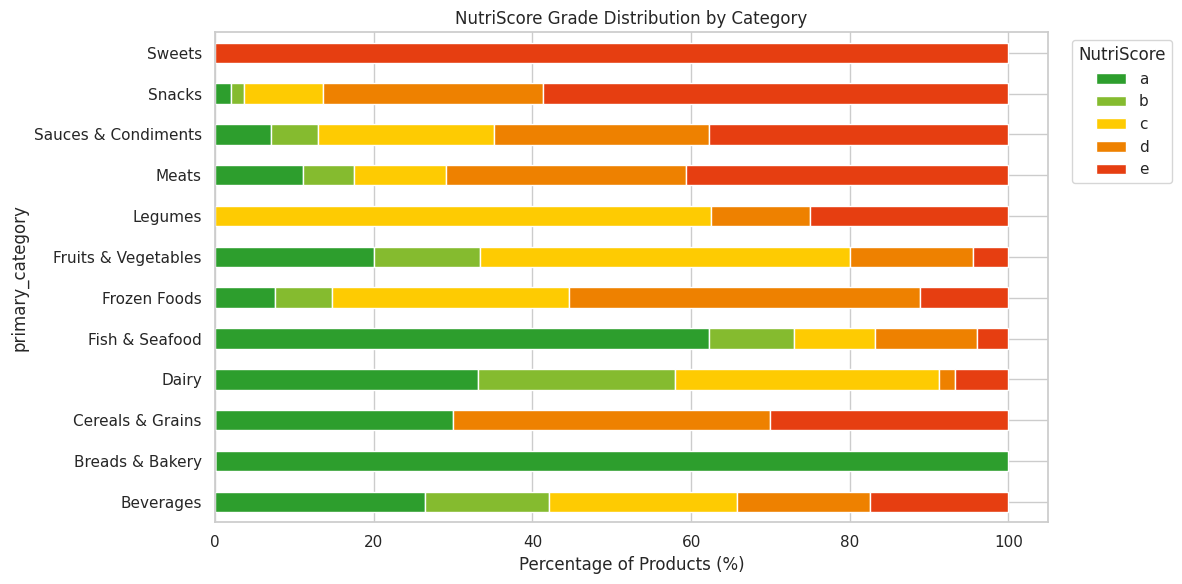

In [ ]:
# Stacked bar: NutriScore grade distribution per category
colors = {"a": "#2d9e2d", "b": "#85bb2f", "c": "#fecb02", "d": "#ee8100", "e": "#e63e11"}
grade_order = ["a", "b", "c", "d", "e"]

fig, ax = plt.subplots(figsize=(12, 6))
grade_dist = grade_dist[grade_order]
grade_dist.plot.barh(stacked=True, ax=ax, color=[colors[g] for g in grade_order])

ax.set_xlabel("Percentage of Products (%)")
ax.set_title("NutriScore Grade Distribution by Category")
ax.legend(title="NutriScore", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [ ]:
# Final combined insight
worst_ns = ns_by_cat.index[0]

Markdown(
    f"###  Candidate's Choice Insight\n\n"
    f"**{worst_ns}** has the worst average NutriScore across all categories. "
    f"Launching a NutriScore A/B product in this space would provide a "
    f"significant on-shelf competitive advantage, especially in EU markets "
    f"where NutriScore labelling influences purchasing decisions."
)

###  Candidate's Choice Insight

**Sweets** has the worst average NutriScore across all categories. Launching a NutriScore A/B product in this space would provide a significant on-shelf competitive advantage, especially in EU markets where NutriScore labelling influences purchasing decisions.

In [ ]:
import os
os.makedirs("data", exist_ok=True)

# 1. Dashboard data: only categorised rows, only the columns the app needs
EXPORT_COLS = [
    "product_name", "brands", "primary_category",
    "sugars_100g", "proteins_100g", "fat_100g", "fiber_100g",
    "nutriscore_grade",
]
export_df = df[df["primary_category"] != "Other"][EXPORT_COLS].copy()
export_df.to_csv("data/dashboard_data.csv", index=False)
print(f"Exported {len(export_df):,} rows to data/dashboard_data.csv")

# 2. Protein sources summary (tiny file)
protein_sources.to_csv("data/protein_sources.csv", header=["count"])
print(f"Exported protein sources to data/protein_sources.csv")

Exported 166,809 rows to data/dashboard_data.csv
Exported protein sources to data/protein_sources.csv
